In [5]:
# get the model from github

!git clone https://github.com/AntonioSkara132/LangPathModel.git

Cloning into 'LangPathModel'...
remote: Enumerating objects: 659, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 659 (delta 49), reused 51 (delta 24), pack-reused 577 (from 1)
Receiving objects: 100% (659/659), 165.89 MiB | 6.29 MiB/s, done.
Resolving deltas: 100% (362/362), done.


### **Initialization**

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline
!apt-get -y update && apt-get -y install ffmpeg


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,553 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,008 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Pac

###**Dataset Creation**

In [ ]:
!git clone https://huggingface.co/datasets/Tonio123/CaptyShapes -b main

Cloning into 'CaptyShapes'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 15 (delta 3), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (15/15), 5.14 KiB | 1.71 MiB/s, done.
Filtering content: 100% (3/3), 811.02 MiB | 153.48 MiB/s, done.


In [7]:
# you can use this script to generate dataset, n is number of instance per annotation, dataset on hugging face
# has 5000 instances per class you could lower it down to 500 to try out the learning process
!python /content/LangPathModel/data/shapes.py --out_file "smaller_mixed_paths.pt" --n 1000 --density 0.025

Generating dataset → smaller_mixed_paths.pt
• circle in the middle  (circle × 1000)
• Written 1/5
/content/LangPathModel/data/shapes.py:36: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return points + np.random.normal(scale=noise_level, size=points.shape)
/content/LangPathModel/data/shapes.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  path_tensor[:, :2] = torch.tensor(add_noise(path_tensor[:, :2]), dtype=torch.float32).clone().detach()
  ↳ wrote 1000 items  →  smaller_mixed_paths.pt [total: 1000]
• circle on the right side  (circle × 1000)
• Written 2/5
  ↳ wrote 1000 items  →  smaller_mixed_paths.pt [total: 2000]
• circle on the left side  (circle × 1000)
• Written 3/5
  ↳ wrote 1000 items  →  smaller_mixed_paths.pt [total: 3000]
• circ

###**Data visualization**

tokenizer_config.json: 100% 48.0/48.0 [00:00<00:00, 347kB/s]
config.json: 100% 570/570 [00:00<00:00, 4.54MB/s]
vocab.txt: 100% 232k/232k [00:00<00:00, 1.08MB/s]
tokenizer.json: 100% 466k/466k [00:00<00:00, 1.05MB/s]


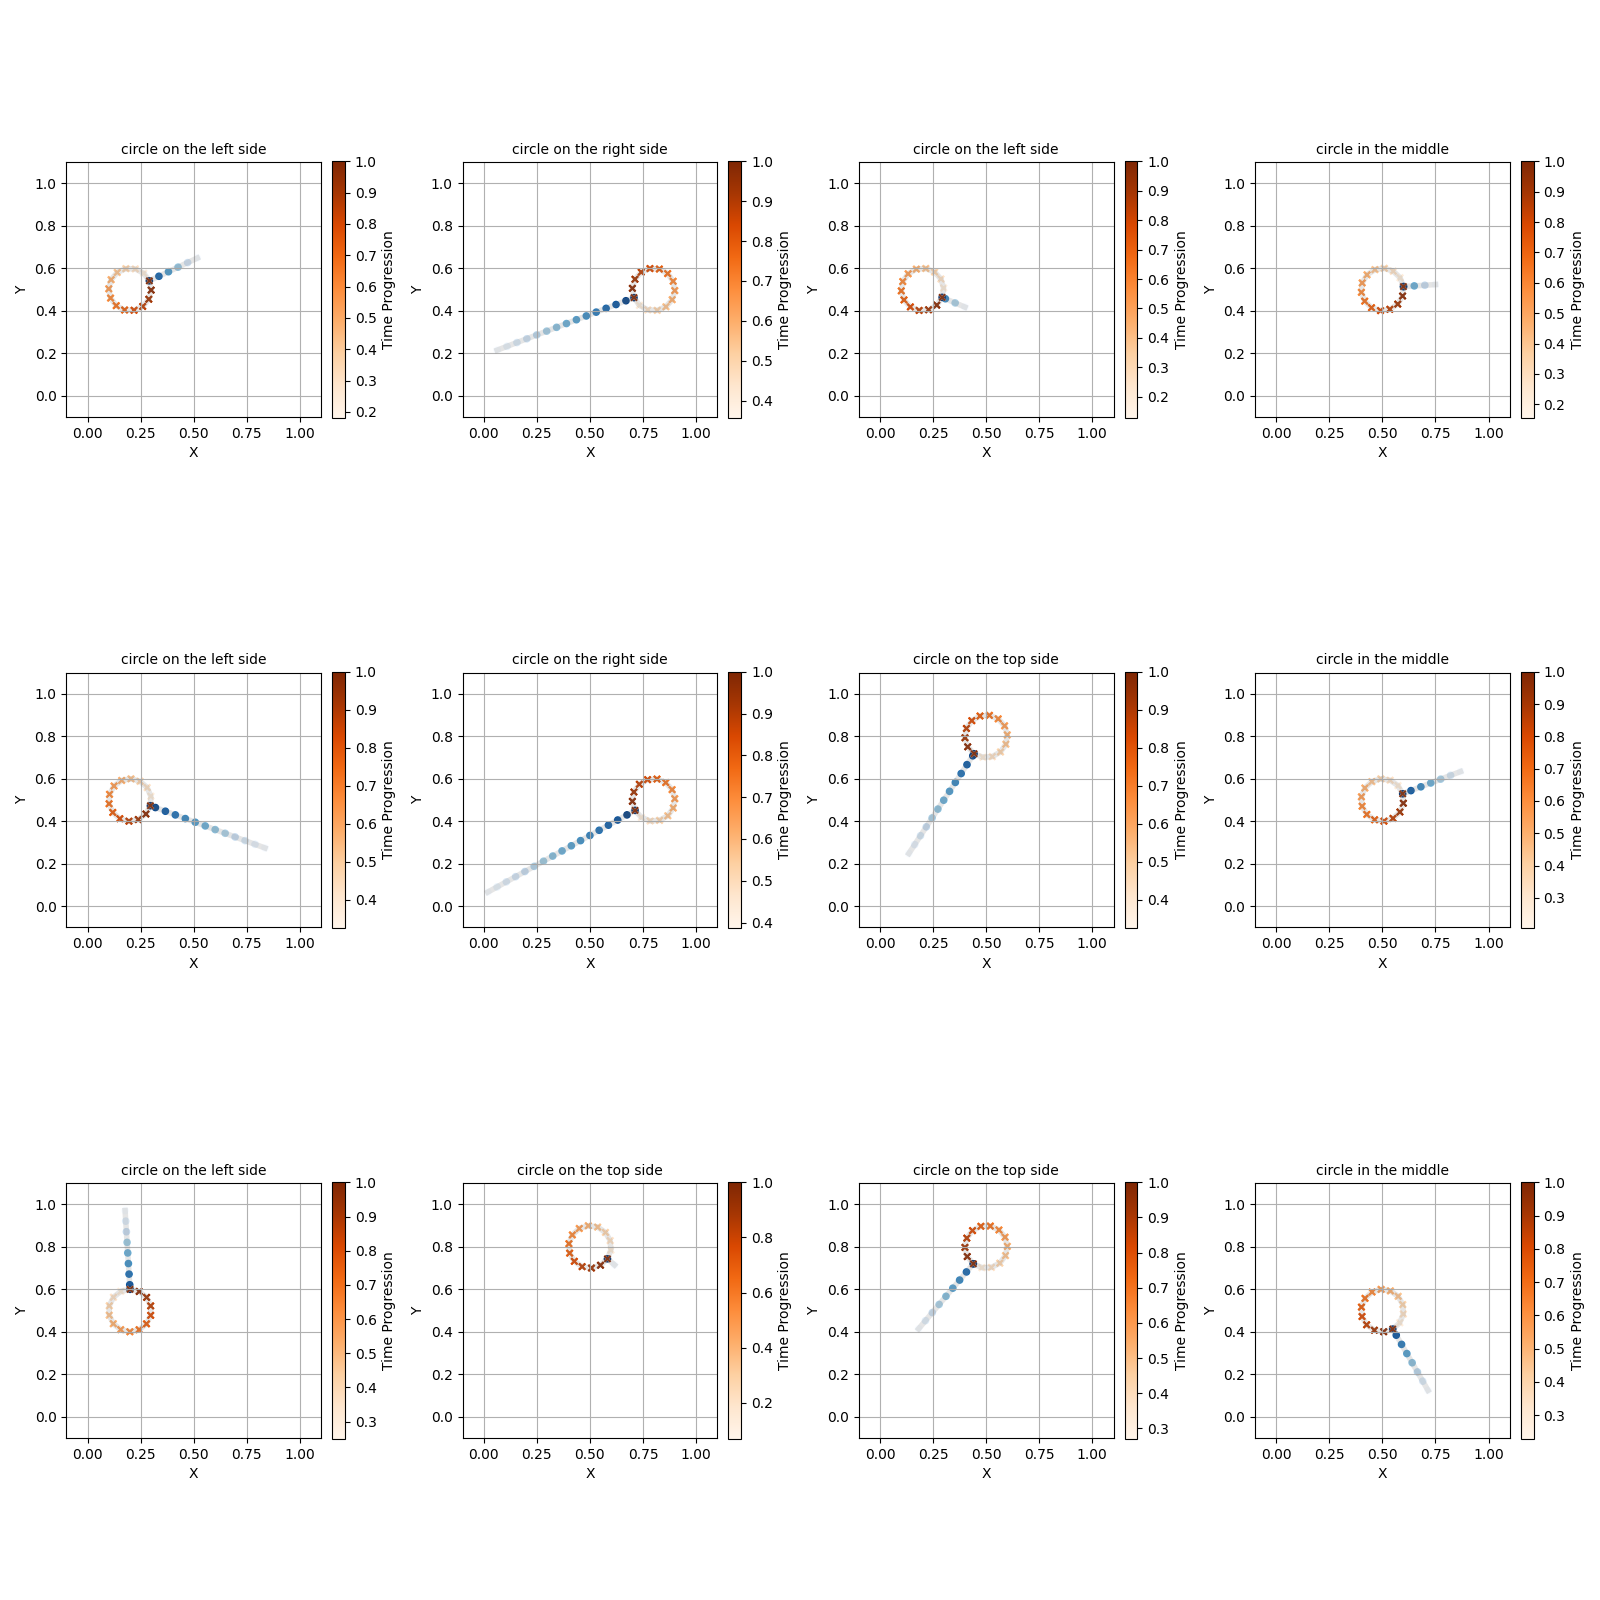

In [8]:
!python /content/LangPathModel/data/data_visualization.py /content/smaller_mixed_paths.pt
display(Image("visualization.png"))


In [ ]:
!python /content/LangPathModel/data/analyze_dataset.py /content/smaller_mixed_paths.pt

Dataset: /content/smaller_mixed_paths.pt
Total paths: 45000
Unique labels: 5
Average points per path: 36.57
Average path length: 0.9776

 Paths per label:
  - 'circle on the right side': 10000 paths | Avg points: 36.8 | Avg length: 0.9873
  - 'circle on the left side': 10000 paths | Avg points: 36.7 | Avg length: 0.9842
  - 'circle on the bottom side': 10000 paths | Avg points: 36.7 | Avg length: 0.9861
  - 'circle on the top side': 10000 paths | Avg points: 36.7 | Avg length: 0.9867
  - 'circle in the middle': 5000 paths | Avg points: 35.2 | Avg length: 0.9099


###**Training**

In [10]:
!python LangPathModel/src/training.py \
  --niter 60 \
  --start_lr 0.001 \
  --lr_step 30 \
  --weight_decay 0 \
  --d_model 128 \
  --num_heads 8 \
  --num_decoder_layers 4 \
  --dropout 0.1 \
  --gamma 0.1 \
  --batch_size 64 \
  --dataset_path /content/smaller_mixed_paths.pt \
  --output_path /content/myModel.pth\
  --ckpt_path /content/LangPathModel/checkpoints
#for testing use small_dataset.pt instead of all shapes.pt

2025-06-05 17:02:53.983583: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-05 17:02:54.000302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749142974.021354    4515 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749142974.027928    4515 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-05 17:02:54.048523: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

###**Evaluate**

In [14]:
!ls
!python LangPathModel/src/evaluate_model.py \
        --model_path "/content/myModel.pth" \
        --prompt "circle on the bottom side" \
        --x0 0.1 \
        --y0 0.1
#x0 and y0 are staring point of the trajectory

drive	 LangPathModel	 sample_data		  smaller_mixed_paths.pt
fig.png  LangPathModel2  smaller_mixed_paths2.pt  visualization.png
Using device → cpu
2025-06-05 17:07:48.457300: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-05 17:07:48.474202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749143268.495410    5985 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749143268.501831    5985 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registe

###**Add velocities and export it as csv**

In [1]:
!python LangPathModel/src/run_and_export.py \
        --model_path "/content/myModel.pth" \
        --prompt "square on the top side" \
        --csv_out "/content/trajectory.csv" \
        --x0 0.1 \
        --y0 0.1 \